### 初始化特徵-前置動作

需先進行檔案的關節點辨識 bboxInfoPredictor.py => keypointPredictor.py => 取得每一幀的關節點位置

下列block為取得keypoints位置與變動量。

In [25]:
import _init_paths
import numpy as np
from lib.config import cfg
from lib.config import update_config
update_config(cfg)
from lib.common.humanKeypoints import humanKeypoints 

infantKeypoint = humanKeypoints('infant_60.mov')
variability = infantKeypoint.getKeypointVariability()


透過每段變動量計算移動平均值，在從移動平均值抽取出特徵，特徵如下所示

* "acceleration": 移動平均加速度
* "deceleration": 移動平均減速度,
* "movment_duration": 移動長度,
* "mean": 移動平均平均值,
* "max": 移動平均最大值,
* "std": 移動平均標準差,
* "skew": 移動平均偏態,
* "peaks_num": 峰值個數

In [26]:
from lib.utils.peakFeature import peakFeature
import pandas as pd
from os import listdir
from os.path import isfile, join

# 讀取資料夾內所有影片名稱
video_floder_path = './data/medias'
video_names = [f for f in listdir(video_floder_path) if isfile(join(video_floder_path, f))]

# 取得移動平均值相關特徵
df = pd.DataFrame()
for video_name in video_names:
    infantKeypoint = humanKeypoints(video_name)
    average_movement = infantKeypoint.getAverageMovement(72)
    average_movement = np.delete(average_movement, [0,1,2,3,4], axis=0)
    average_movement =average_movement[..., ::cfg.DOWNSAMPLING]
    pf = peakFeature(average_movement, video_name)
    features = pf.getPeakFeatures()

    # 避免為空值
    if df.empty:
        df = pd.DataFrame(features)
    else:
        df = pd.concat([df, pd.DataFrame(features)])

計算Kmeans 挑選效果最佳的K值 數值越高代表越好

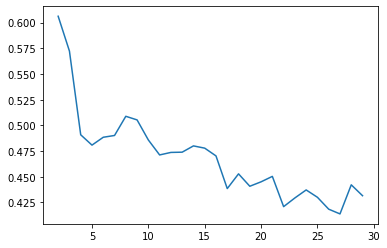

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt

# 取得特徵資料欄位範圍
X = df.loc[:,'acceleration':]
sil = []
for k in np.arange(2,30):
    kmeans = KMeans(n_clusters=k, random_state=2).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))

plt.plot(np.arange(2,30), sil)

使用Kmeans進行分類，並給定分類結果

In [28]:
import matplotlib.pyplot as plt 
kmeans = KMeans(n_clusters=10, random_state=2).fit(X)
ndf = df
ndf['peakCluster'] = kmeans.labels_

使用GMM進行分類，並給定分類結果

In [29]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=10, random_state=2).fit(X)
ndf['peakCluster'] = gm.predict(X)


畫出由GMM或Kmeans所分類出的結果

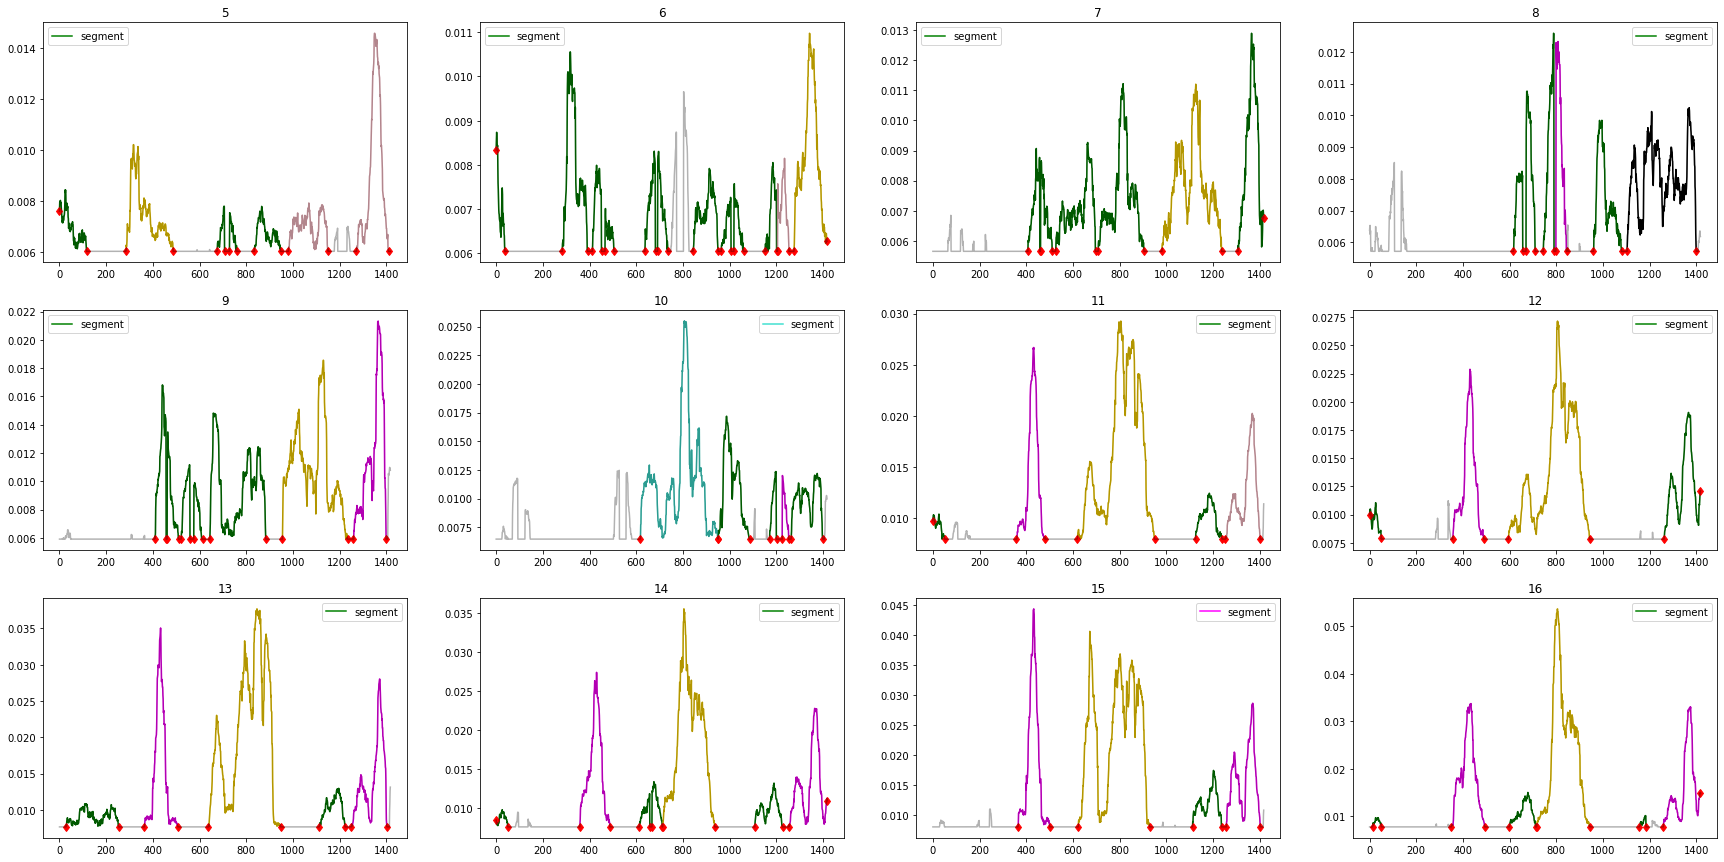

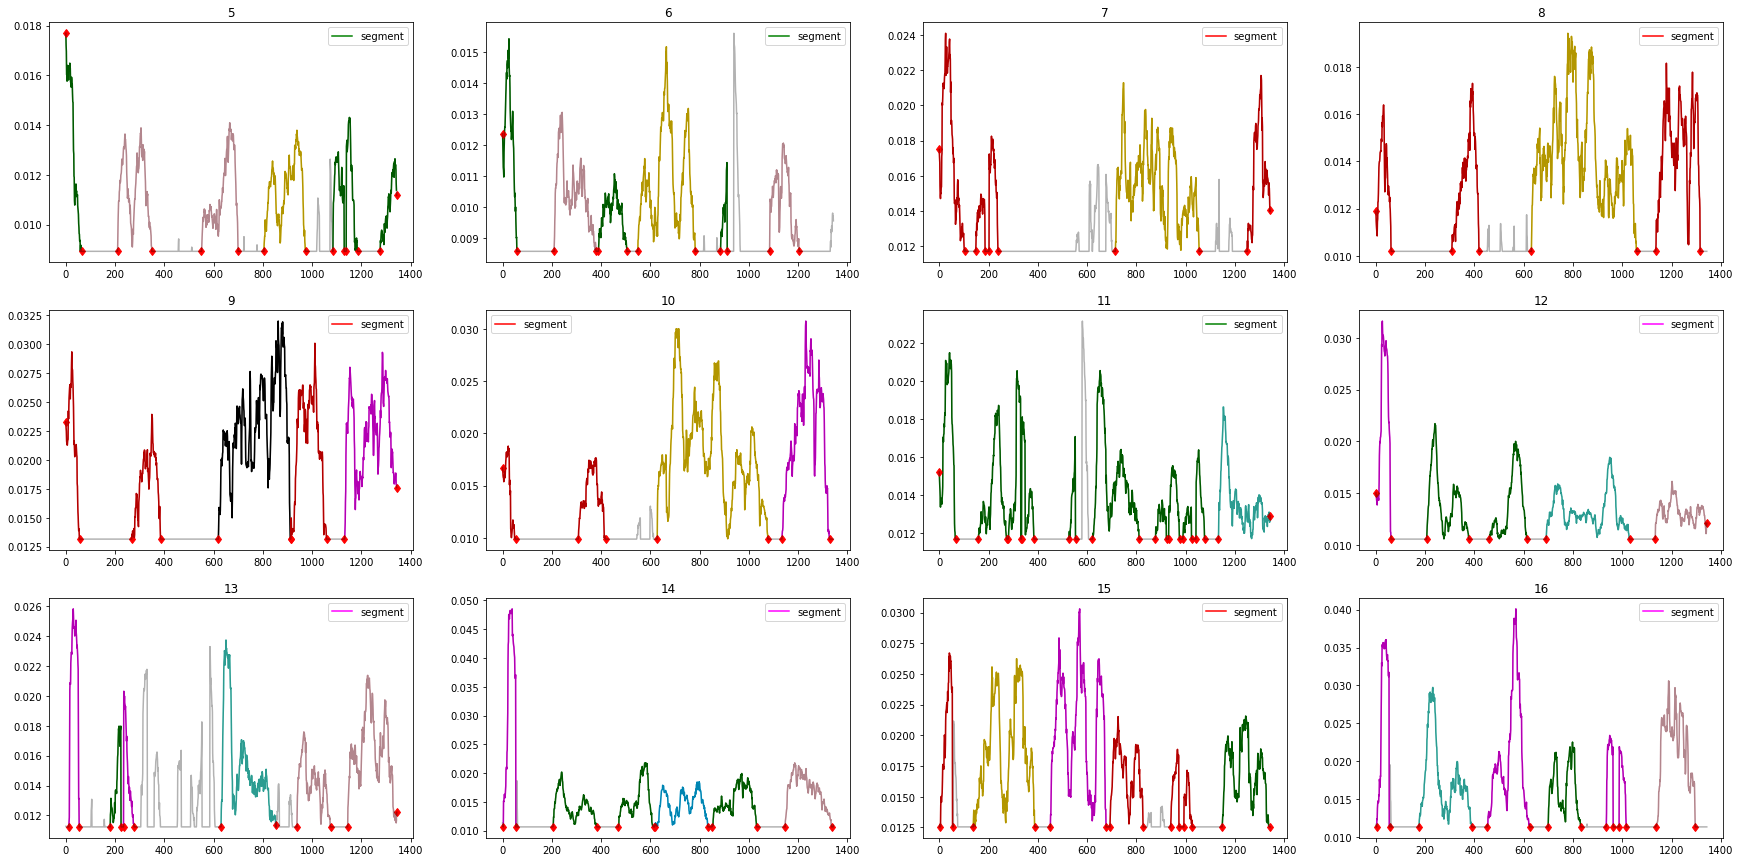

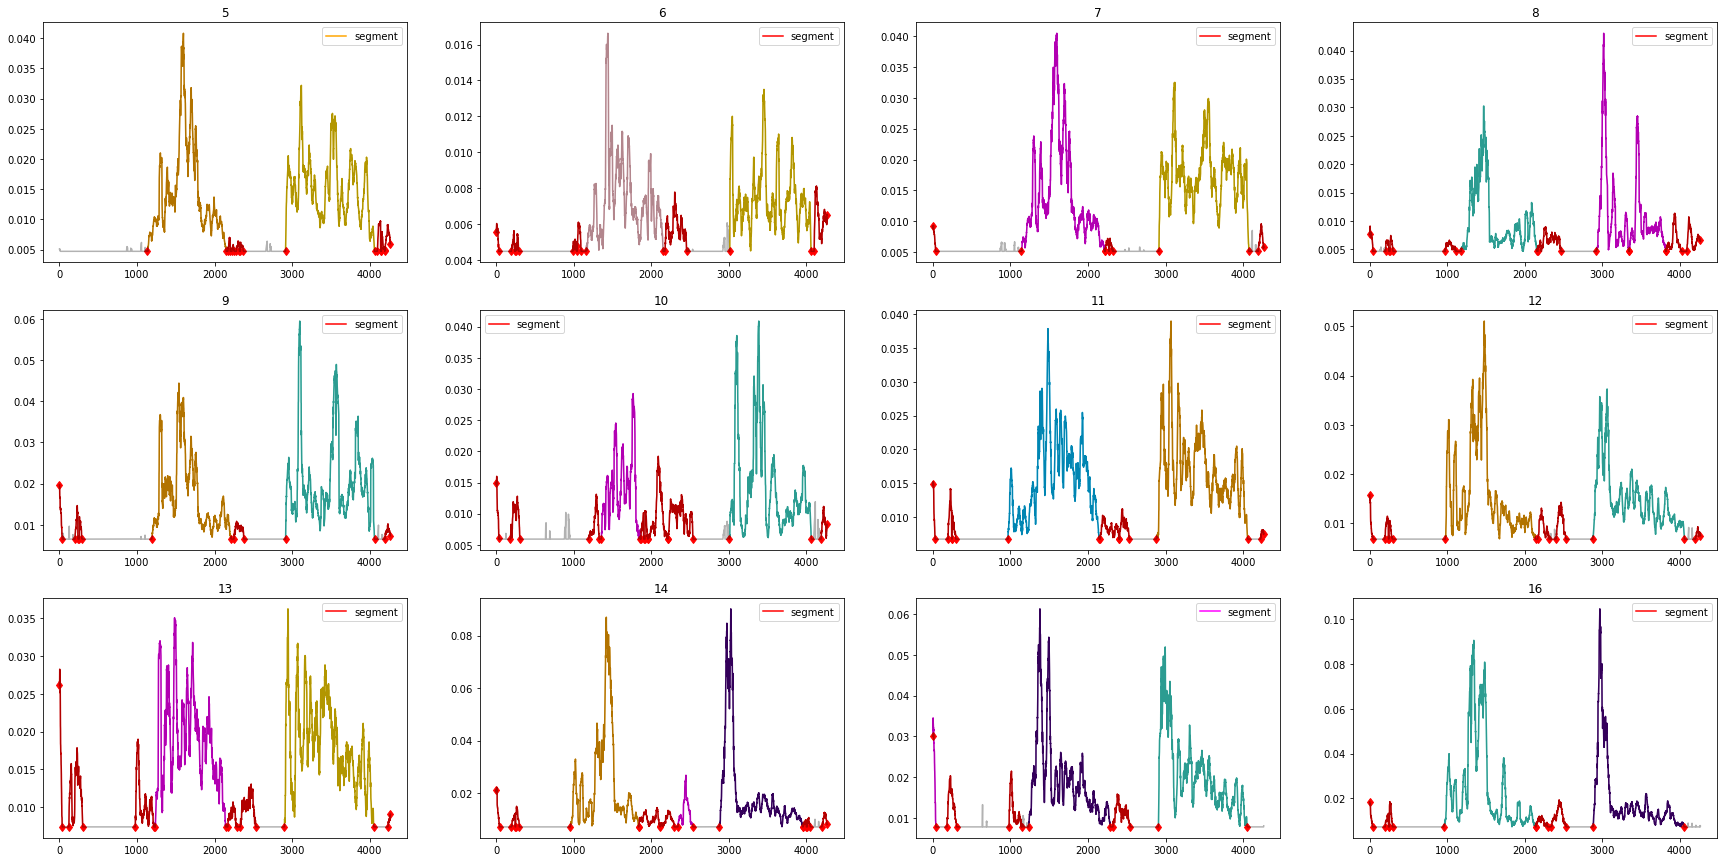

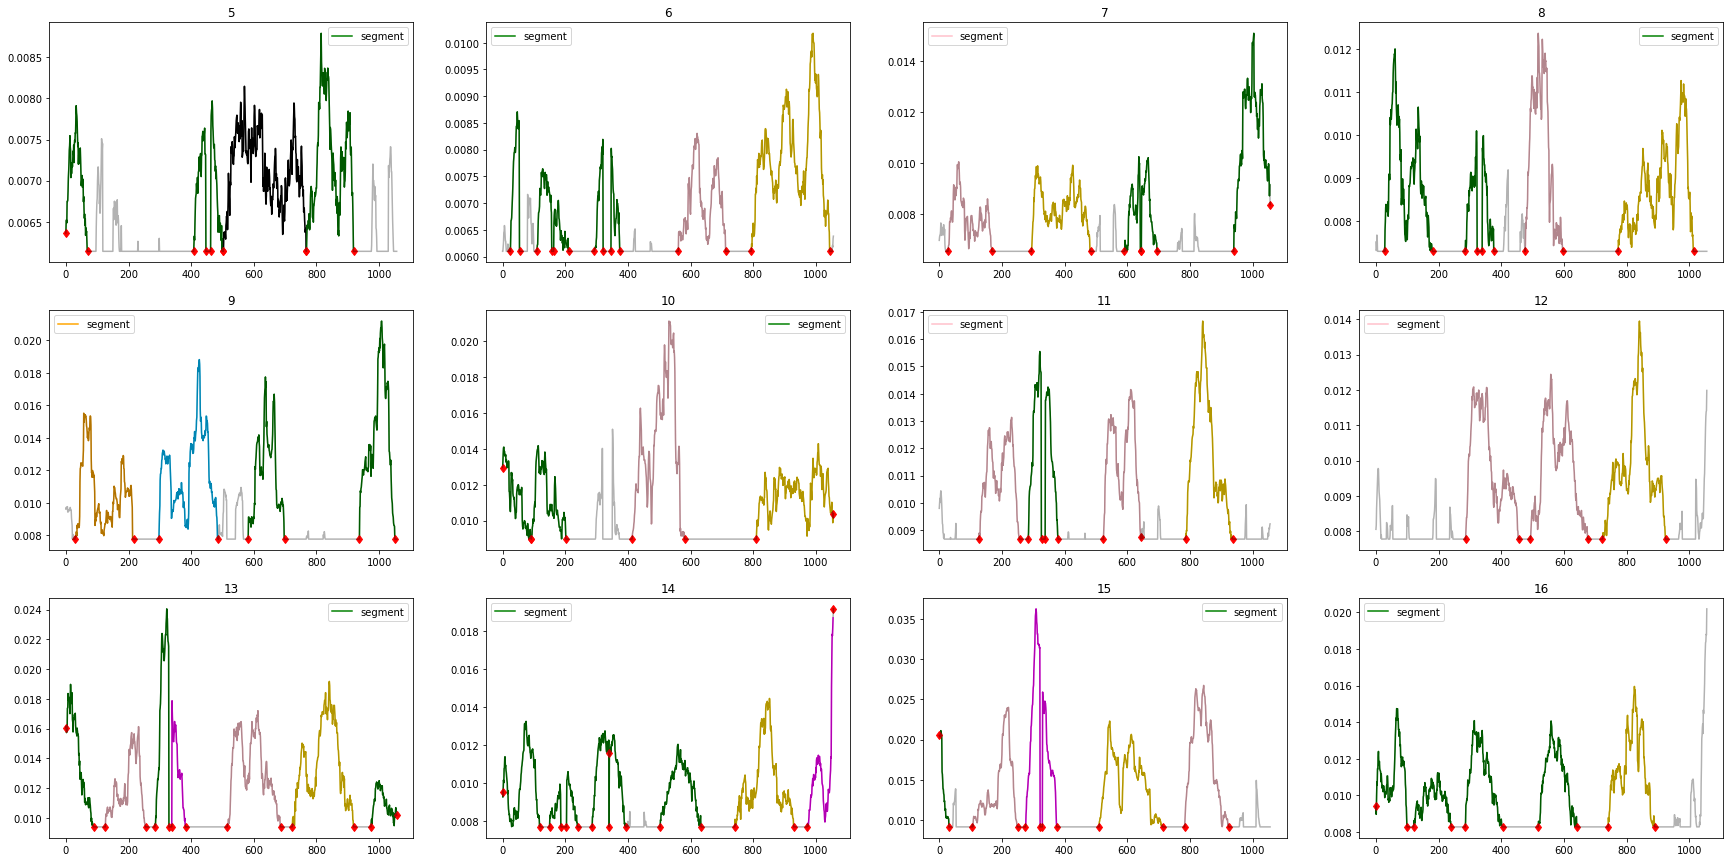

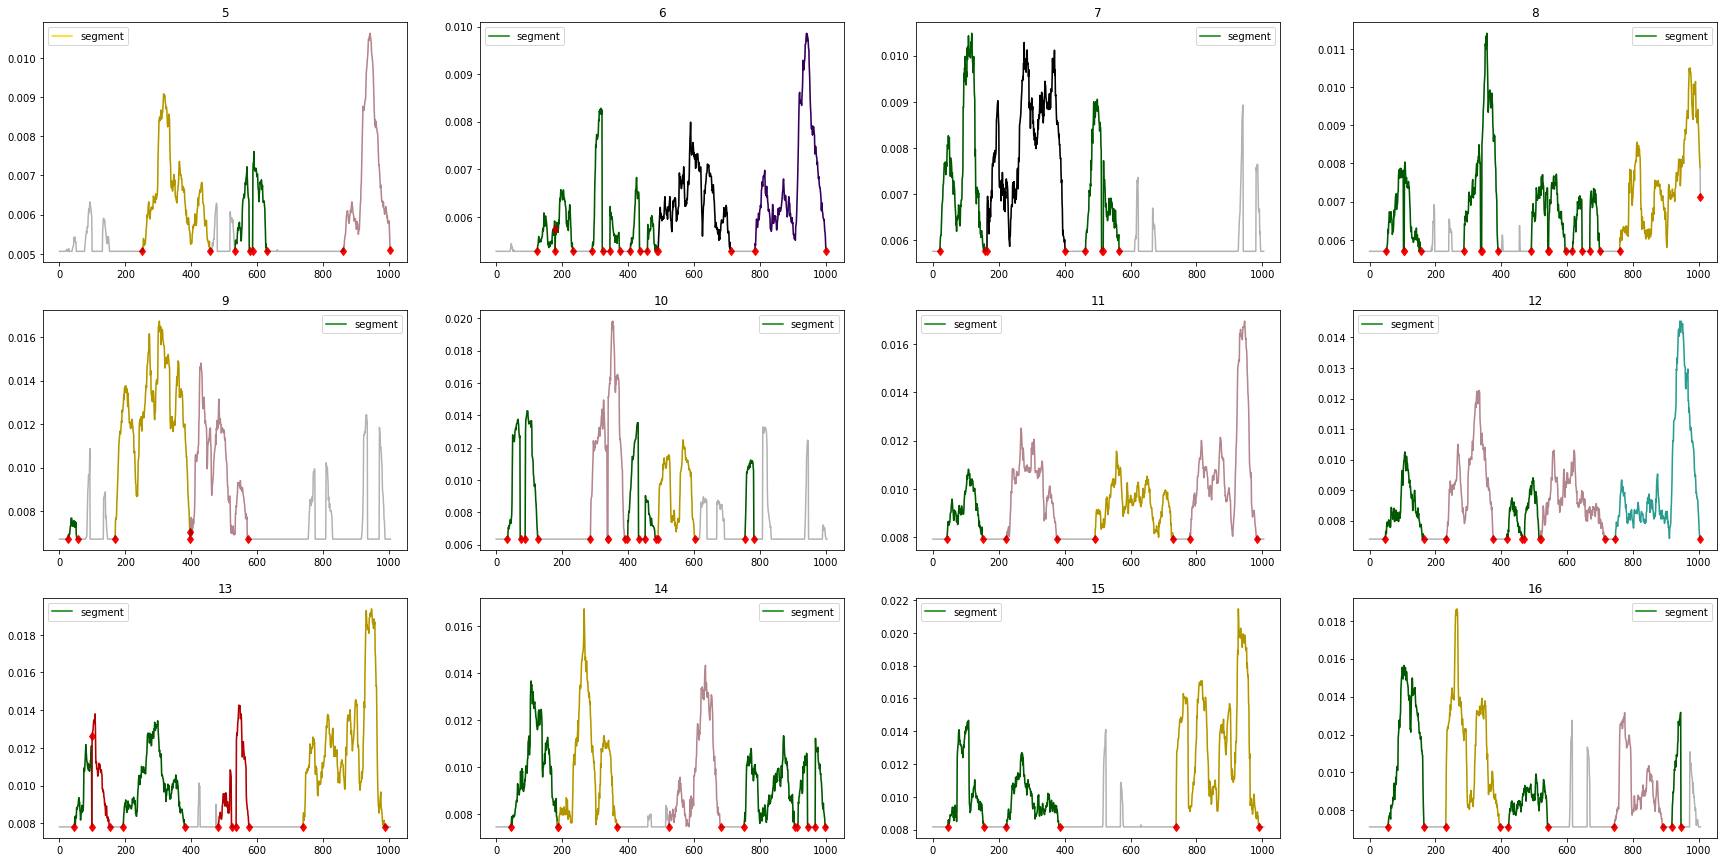

In [30]:

for video_name in video_names:
    infantKeypoint = humanKeypoints(video_name)
    average_movement = infantKeypoint.getAverageMovement(72)
    average_movement = np.delete(average_movement, [0,1,2,3,4], axis=0)
    average_movement =average_movement[..., ::cfg.DOWNSAMPLING]
    pf = peakFeature(average_movement, video_name)
    data = pf.getVisualizeData()

    v = visualization(infantKeypoint)
    v.draw_peak_feature(ndf, data, video_name)
    